In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Activation
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt

# 1. Set up data

Download data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define root path
directory_path = "/content/drive/MyDrive/Master/20202/ProjetM1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data:

In [ ]:
def loadCSV(directory_path, csv_file, delimiter):
    data_path = os.path.join(directory_path, os.path.join("data", "nsl_kdd"))
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path, header=None)
    df = df.dropna(inplace=False)
    return df

In [ ]:
df_train = loadCSV(directory_path, "train.csv", ",")
df_test = loadCSV(directory_path, "test.csv", ",")

# !wget -O KDDTrain+.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv  # NSL_KDD Train
# !wget -O Small_Training_Set.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Small%20Training%20Set.csv  # Small Training Set

# df_train = loadCSV(os.getcwd(), "KDDTrain+.csv", ",")
# df_test = loadCSV(os.getcwd(), "KDDTest+.csv", ",")

## 2. Data Analysis

Take a look at the labels:

In [ ]:
label_train_raw = df_train[41].value_counts()
label_train_raw

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64

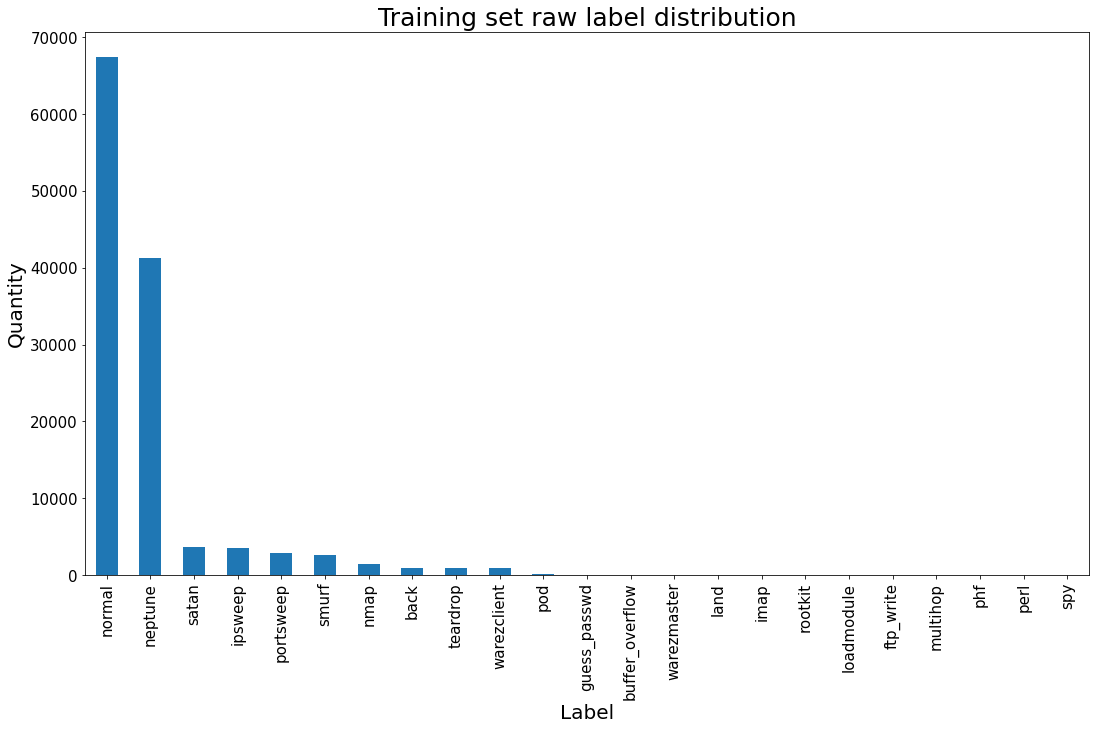

In [ ]:
label_train_raw.plot.bar(x="Quantity", y="Label", figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Training set raw label distribution', fontsize=25)
plt.xlabel('Label', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.show()

In [ ]:
label_test_raw = df_test[41].value_counts()
label_train_raw

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64

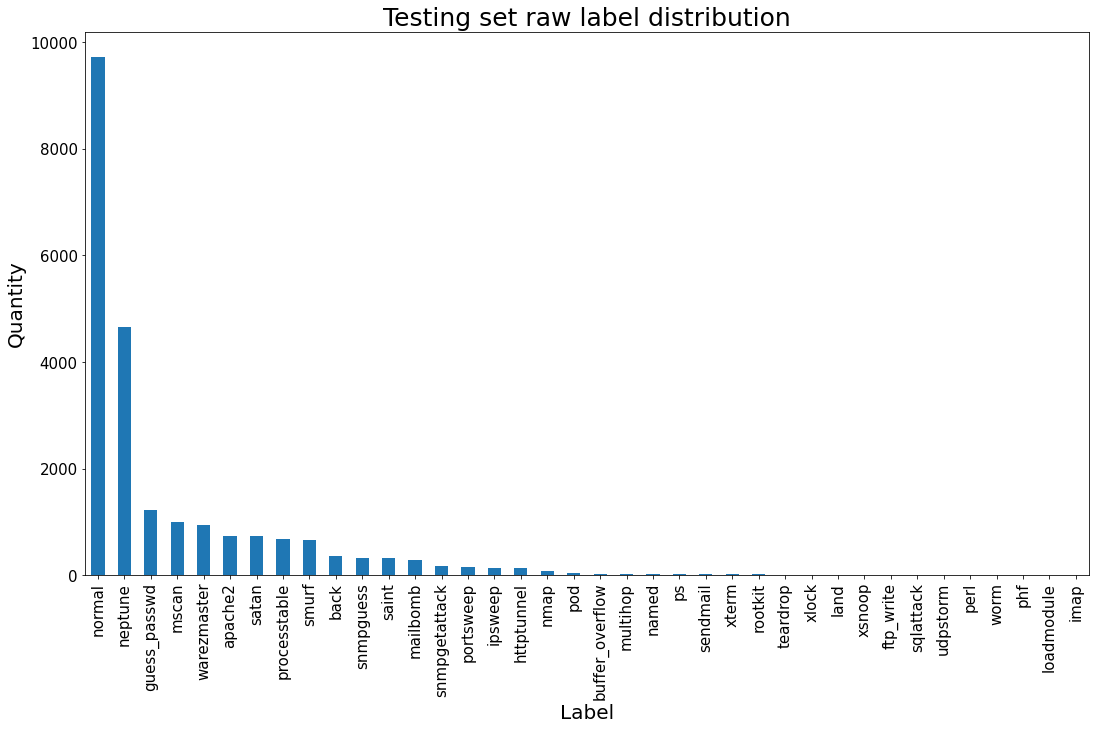

In [ ]:
label_test_raw.plot.bar(x="Quantity", y="Label", figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Testing set raw label distribution', fontsize=25)
plt.xlabel('Label', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.show()

In [ ]:
label_test_raw = df_test[41].value_counts()
label_test_raw

normal             9710
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
sqlattack             2
udpstorm              2
perl                  2
worm                  2
phf                   2
loadmodule            2
imap                  1
Name: 41, dtype: int64

Separate and encode features and labels

- Classify the label (22 features) into five categories:
    - Normal Traffic
    - DoS attack
    - Probing attack
    - User-to-Root (Privilege Escalation) attack
    - Remote-to-Local (Exploitation) attack

In [ ]:
df_train = loadCSV(directory_path, "train.csv", ",")
df_test = loadCSV(directory_path, "test.csv", ",")

Determine the number of labels (2 or 5):

In [ ]:
number_of_label = 5

In [ ]:
# Column 1, 2, and 3 are object
def encodeFeature(df):
    df_feature = df.drop([41, 42], axis=1)
    categorical_feature = [1, 2, 3]
    for feature in categorical_feature:
        df_feature[feature] = df[feature].astype('category').cat.codes
    
    return df_feature


# Change label data from categorical to numeric
def changeLabel(outcome, number_of_label):
    assert number_of_label in [2,5], "number of feature must be between 2 or 5"
    
    # Label list
    normal = ['normal']
    dos = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
    probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
    u2r = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
    r2l = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']
    label_list = [normal, dos, probe, u2r, r2l]


    for label in range(len(label_list)):
        if outcome.lower() in label_list[label]:
            # 5 labels
            if number_of_label == 5:
                result = label
                return result
            # 2 labels
            elif number_of_label == 2:
                if label == 0:
                    result = 0
                else:
                    result = 1
                return result
            
# Classify label into 5 categories, and convert them to numeric
def encodeLabel(df, number_of_label):
    df_label = df.iloc[:, 41].copy()
    df_label = df_label.apply(changeLabel, number_of_label=number_of_label)
    return df_label

In [ ]:
# Encode data
df_feature_train = encodeFeature(df_train)
df_label_train = encodeLabel(df_train, number_of_label)
df_feature_test = encodeFeature(df_test)
df_label_test = encodeLabel(df_test, number_of_label)

Label distribution:

In [ ]:
label_train = df_label_train.value_counts()
print(label_train)

0    67343
1    45927
2    11656
4      995
3       52
Name: 41, dtype: int64


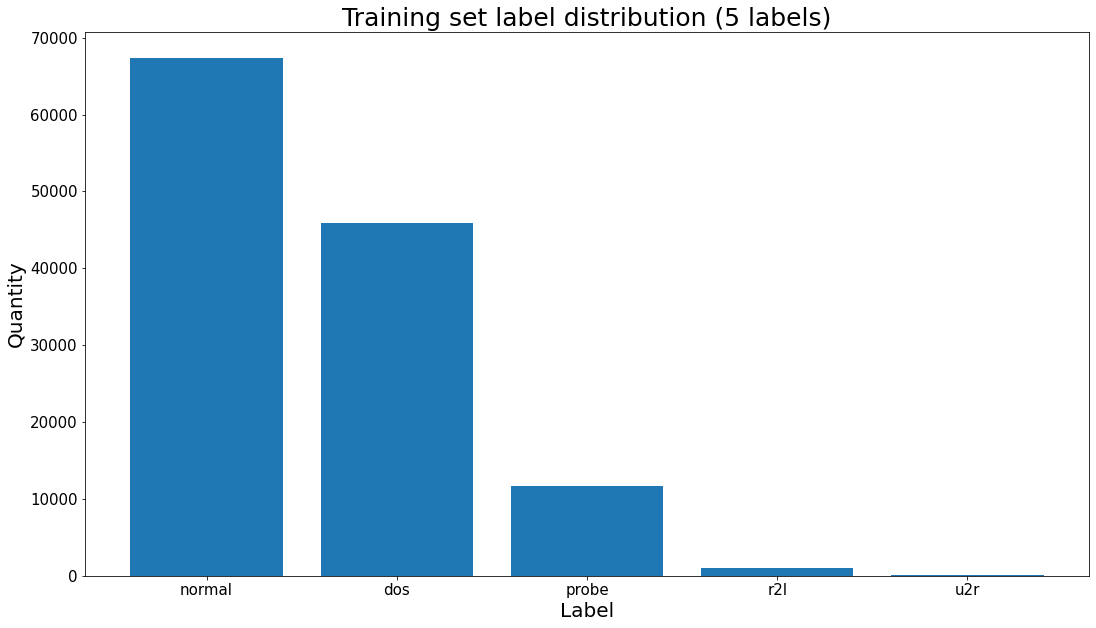

In [ ]:
if number_of_label == 5:
    index = ['normal', 'dos', 'probe', 'r2l', 'u2r']
    plt.figure(figsize=(18,10))
elif number_of_label == 2:
    index = ["normal", "abnormal"]
    plt.figure(figsize=(14,10))

plt.bar(index, label_train)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Training set label distribution ({} labels)'.format(number_of_label), fontsize=25)
plt.xlabel('Label', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.show()

In [ ]:
label_test = df_label_test.value_counts()
print(label_test)

0    9710
1    7460
4    2885
2    2421
3      67
Name: 41, dtype: int64


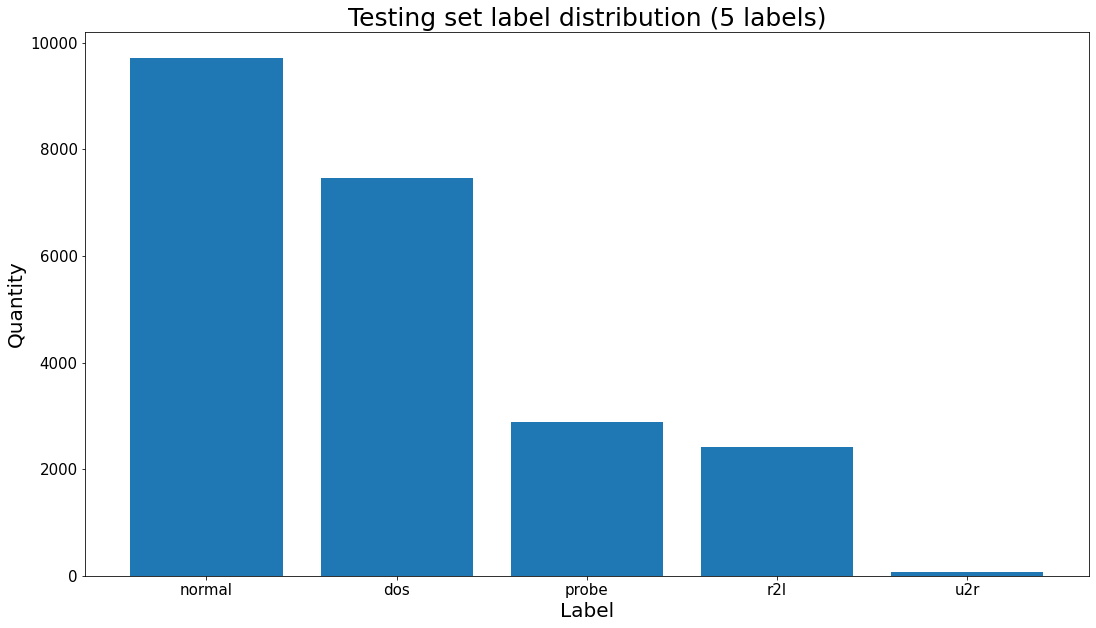

In [ ]:
if number_of_label == 5:
    index = ['normal', 'dos', 'probe', 'r2l', 'u2r']
    plt.figure(figsize=(18,10))
elif number_of_label == 2:
    index = ["normal", "abnormal"]
    plt.figure(figsize=(14,10))

plt.bar(index, label_test)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Testing set label distribution ({} labels)'.format(number_of_label), fontsize=25)
plt.xlabel('Label', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.show()

Normalize the datasets:

In [ ]:
def normalize(df):
    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)
    return df

In [32]:
X_train = normalize(df_feature_train)
X_test = normalize(df_feature_test)

Y_train = df_label_train.to_numpy()
Y_test = df_label_test.to_numpy()


# Numeric label --> One-hot encoding label
Y_test_one_hot = to_categorical(Y_test)
Y_train_one_hot = to_categorical(Y_train)


# Data reshape for LSTM and GRU [samples, time steps, features]
X_train_timeseries = np.reshape(X_train, (int(X_train.shape[0]), 1, X_train.shape[1]))
X_test_timeseries = np.reshape(X_test, (int(X_test.shape[0]), 1, X_test.shape[1]))




# Model creation, training and prediction

Load saved model and predict:

In [33]:
model = Sequential()
model.add(LSTM(16,input_dim=X_train.shape[1], return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(8,input_dim=X_train.shape[1], return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(number_of_label))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Create checkpoint
checkpoint_path = os.path.join(directory_path, "checkpoints")
checkpointer = callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_path, "checkpoint-{epoch:02d}.hdf5"), verbose=0, save_best_only=True, monitor='loss', save_freq='epoch', period=200)
csv_logger = callbacks.CSVLogger(os.path.join(directory_path, "logger.csv"),separator=';', append=False)
model.summary()


# Training
history = model.fit(X_train_timeseries, Y_train_one_hot, batch_size=32, epochs=5, validation_split=0.15, callbacks=[checkpointer,csv_logger], verbose=0)

# Evaluate and score
score = model.evaluate(X_test_timeseries, Y_test_one_hot)
name_model = "model_2_{:.4f}.h5".format(score[1])
model.save(os.path.join(directory_path, name_model))


Prediction and evaluation on test set:

LSTM: 30 epochs
```
model = Sequential()
model.add(LSTM(16,input_dim=X_train.shape[1], return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(8,input_dim=X_train.shape[1], return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(number_of_label))
model.add(Activation('softmax'))
```

MLP 30 epochs
```
model = keras.Sequential()
model.add(layers.Dense(1024, activation = 'relu', input_shape = (X_train.shape[1],)))
model.add(Dropout(0.7))
model.add(layers.Dense(512, activation = 'relu'))
model.add(Dropout(0.7))
model.add(layers.Dense(number_of_label, activation = 'softmax'))
```

In [ ]:
Y_pred = model.predict(X_test)

for index in range(len(Y_pred)):
    idx_max_predict = np.argmax(Y_pred[index])
    for idx_predict in range(len(Y_pred[index])):
        if idx_predict == idx_max_predict:
            Y_pred[index][idx_predict] = 1
        else:
            Y_pred[index][idx_predict] = 0

print(classification_report(Y_test_one_hot, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6266    0.9774    0.7636      9710
           1     0.9671    0.7408    0.8389      7460
           2     0.8690    0.5481    0.6722      2421
           3     1.0000    0.0299    0.0580        67
           4     0.9474    0.0499    0.0948      2885

   micro avg     0.7315    0.7315    0.7315     22543
   macro avg     0.8820    0.4692    0.4855     22543
weighted avg     0.8075    0.7315    0.6910     22543
 samples avg     0.7315    0.7315    0.7315     22543



Load previous models:

In [ ]:
name_model = "final_model_0.7702.h5"


if "lstm" in name_model or "gru" in name_model:
    X_test = X_test_timeseries
else:
    X_test = normalize(df_feature_test)
model = keras.models.load_model(os.path.join(directory_path, name_model))
score = model.evaluate(X_test, Y_test_one_hot)
# model.save(os.path.join(directory_path, ""))

Y_pred = model.predict(X_test)

for index in range(len(Y_pred)):
    idx_max_predict = np.argmax(Y_pred[index])
    for idx_predict in range(len(Y_pred[index])):
        if idx_predict == idx_max_predict:
            Y_pred[index][idx_predict] = 1
        else:
            Y_pred[index][idx_predict] = 0

print(classification_report(Y_test_one_hot, Y_pred, digits=4))

Loss Value on training phase:

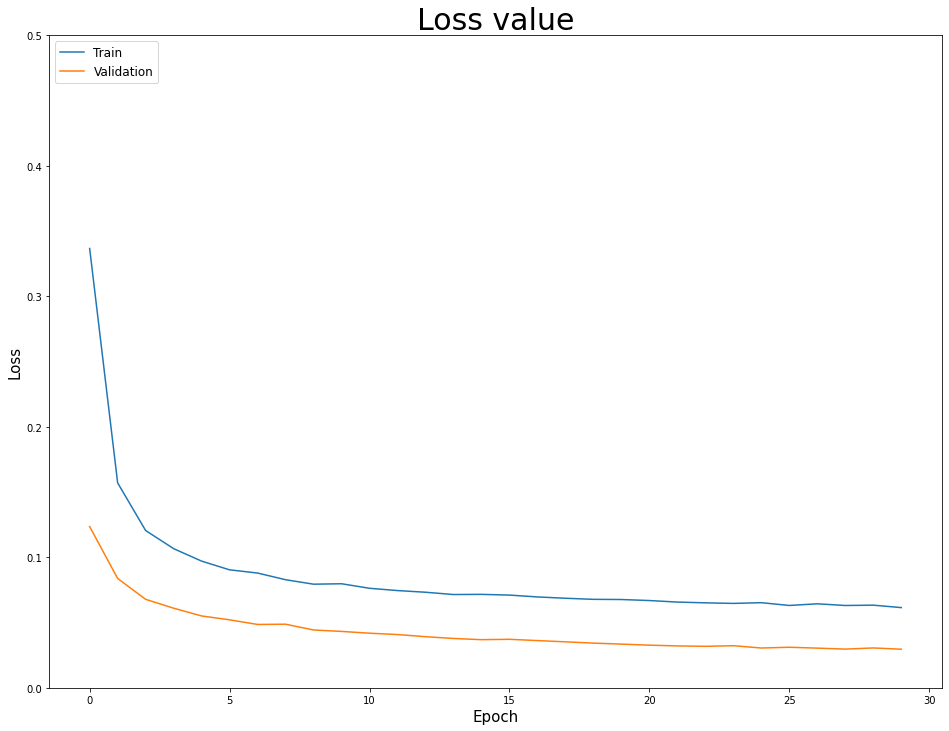

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss value", fontsize=30)
plt.ylabel('Loss', fontsize=15)
plt.ylim(ymin=0, ymax=0.5)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.show()

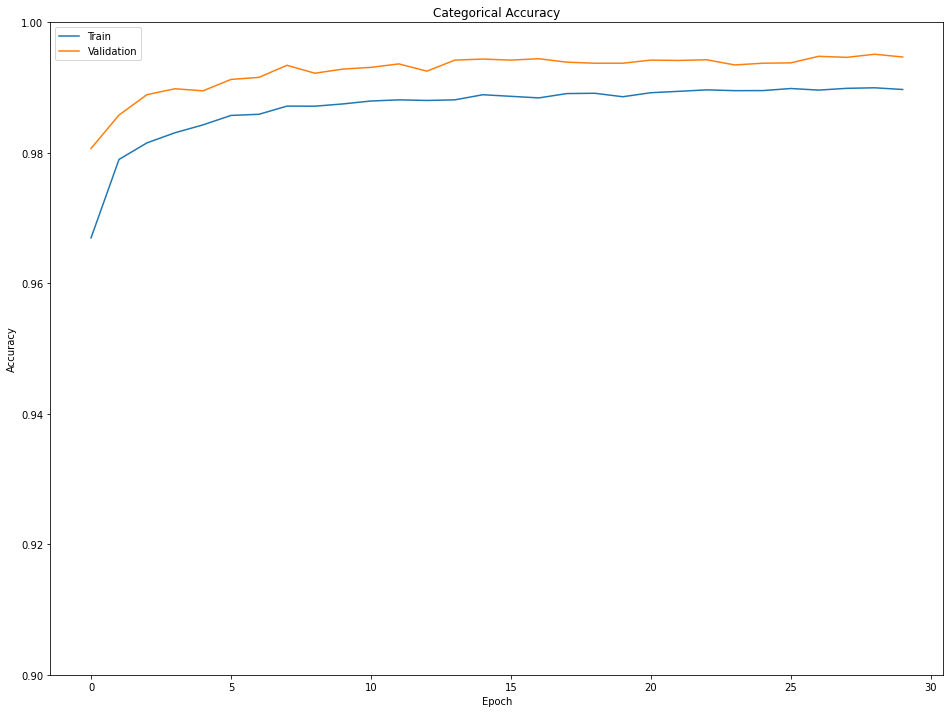

In [ ]:
# summarize history for accuracy
# plt.plot(history.history['loss'])
plt.figure(figsize=(16,12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Categorical Accuracy')
plt.ylim(0.9, 1) 
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Different models:

In [ ]:
from sklearn.linear_model import LogisticRegression

softmax = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')

softmax.fit(X_train, Y_train)
Y_pred = softmax.predict(X_test)
print(classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6639    0.9743    0.7896      9710
           1     0.9743    0.7964    0.8764      7460
           2     0.8277    0.7439    0.7836      2421
           3     0.7500    0.0448    0.0845        67
           4     0.5333    0.0028    0.0055      2885

    accuracy                         0.7636     22543
   macro avg     0.7498    0.5124    0.5079     22543
weighted avg     0.7677    0.7636    0.7152     22543



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()

bayes.fit(X_train, Y_train)
Y_pred = bayes.predict(X_test)
print(classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7465    0.1425    0.2394      9710
           1     0.7219    0.7615    0.7412      7460
           2     0.2807    0.9343    0.4317      2421
           3     0.0039    0.0448    0.0071        67
           4     0.2813    0.3882    0.3262      2885

    accuracy                         0.4636     22543
   macro avg     0.4068    0.4543    0.3491     22543
weighted avg     0.6266    0.4636    0.4365     22543



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
print(classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6618    0.9771    0.7892      9710
           1     0.9562    0.7790    0.8585      7460
           2     0.8141    0.6729    0.7368      2421
           3     0.8235    0.2090    0.3333        67
           4     0.9196    0.0357    0.0687      2885

    accuracy                         0.7561     22543
   macro avg     0.8351    0.5347    0.5573     22543
weighted avg     0.8091    0.7561    0.7129     22543



In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

logistic.fit(X_train, Y_train)
Y_pred = logistic.predict(X_test)
print(classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6639    0.9743    0.7896      9710
           1     0.9743    0.7964    0.8764      7460
           2     0.8277    0.7439    0.7836      2421
           3     0.7500    0.0448    0.0845        67
           4     0.5333    0.0028    0.0055      2885

    accuracy                         0.7636     22543
   macro avg     0.7498    0.5124    0.5079     22543
weighted avg     0.7677    0.7636    0.7152     22543



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
